In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpi4py import MPI

# from cosmoprimo.fiducial import DESI

from pmesh.pm import ParticleMesh
from ZeNBu.zenbu import Zenbu
from ZeNBu.zenbu_rsd import Zenbu_RSD

def get_mesh_init(power, boxsize, nmesh):

    pm = ParticleMesh(BoxSize=boxsize, Nmesh=nmesh, dtype='f8', comm=MPI.COMM_WORLD)
    mesh_delta_k = pm.generate_whitenoise(seed=42, type='untransposedcomplex', unitary=True)
    norm = 1.0 / boxsize.prod()

    for kslab, delta_slab in zip(mesh_delta_k.slabs.x, mesh_delta_k.slabs):
        # the square of the norm of k on the mesh
        k2 = sum(kk**2 for kk in kslab)
        k = (k2**0.5).ravel()
        mask_nonzero = k != 0.
        tmp = np.zeros_like(k)
        tmp[mask_nonzero] = power(k[mask_nonzero])

        # multiply complex field by sqrt of power
        delta_slab[...].flat *= (tmp * norm)**0.5

    return mesh_delta_k


def shear(base):
    s2 = base.pm.create(type='real', value=0.)
    kk = base.r2c().x
    k2 = sum(ki**2 for ki in kk)
    zero_mode = (k2 == 0); nonzero = (k2 > 0)
    k2[zero_mode] = 1
    for i in range(3):
        for j in range(i, 3):
            basec = base.r2c()
            basec *= (kk[i]*kk[j] / k2 - (i == j)/3.) * nonzero
            baser = basec.c2r()
            s2[...] += baser**2
            if i != j:
                s2[...] += baser**2
    return s2


def laplace(base):
    kk = base.r2c().x
    k2 = sum(ki**2 for ki in kk)
    basec = base.r2c()
    lapc = -1*basec*k2
    return lapc.c2r()


def get_shifts(mesh_delta_k, positions=None):
    nmesh = mesh_delta_k.pm.Nmesh
    mesh_disp_r = []
    for iaxis in range(mesh_delta_k.ndim):
        psi = mesh_delta_k.copy()
        for kslab, islab, slab in zip(psi.slabs.x, psi.slabs.i, psi.slabs):
            k2 = sum(kk**2 for kk in kslab)
            k2[k2 == 0.] = 1.  # avoid dividing by zero
            mask = islab[iaxis] != nmesh[iaxis] // 2
            slab[...] *= 1j * kslab[iaxis] / k2 * mask
        psi = psi.c2r()
        if positions is not None:
            psi = psi.readout(positions, resampler='nearest')
        mesh_disp_r.append(psi)
        del psi
    if positions is not None:
        return np.column_stack(mesh_disp_r)
    return mesh_disp_r



def get_lagrangian_field(mesh_delta_r, bias, smoothing=0, positions=None):
    if smoothing > 0:

        def tf(k):
            k2 = 0
            for ki in k:
                k2 =  k2 + ki ** 2
            return np.exp(-0.5 * k2 * (smoothing**2))

        base = mesh_delta_r.r2c().apply(lambda k, v: tf(k) * v).c2r()
    else:
        base = mesh_delta_r.copy()

    #one = (base*0 + 1).copy()
    d0 = base.copy()
    d2 = 1.*base**2
    d2 -= d2.cmean()
    s2 = shear(base)
    s2 -= s2.cmean()
    lap = laplace(base)
    lap -= lap.cmean()

    mesh = 1 + sum(mesh * b for mesh, b in zip([d0, d2, s2, lap], bias))
    if positions is not None:
        mesh = mesh.readout(positions, resampler='nearest')
    return mesh


def get_pt(kv, klin, pklin, cutoff=10., f=None):
    """
    Return Zeldovich prediction.

    Parameters
    ----------
    kv : array
        Output k.

    klin : array
        Input linear k.

    pklin : array
        Output P(k).

    f : float
        Growth rate.
    """
    if f is None:  # real space
        zobj = Zenbu(klin, pklin, jn=15, N=3000, cutoff=cutoff)
        zobj.make_ptable(kvec=kv)
        tmp = zobj.pktable.T[1:]  # first is k, drop it
        pktable = np.zeros((14,) + tmp.shape[1:], dtype='f8')
        pktable[:10, ...] = tmp[:10, ...]
        pktable[10:, ...] = -kv[np.newaxis, :]**2 * tmp[[0, 1, 3, 6], ...]  # nabla
        pktable = pktable[:, None, :]
    else:
        lpt = Zenbu_RSD(klin, pklin, jn=15, N=2500, cutoff=cutoff)
        lpt.make_pltable(f, kv=kv, nmax=8, ngauss=3)

        p0table = lpt.p0ktable
        p2table = lpt.p2ktable
        p4table = lpt.p4ktable

        pktable = np.zeros((len(p0table), 3, p0table.shape[-1]))
        pktable[:, 0, :] = p0table
        pktable[:, 1, :] = p2table
        pktable[:, 2, :] = p4table
        pktable = pktable.T

    return pktable


def get_pk(pktable, b1=1., b2=0., bs=0., bk2=0.):
    """Return galaxy power spectrum prediction."""
    pktable = pktable[:14]
    bias_monomials = np.array([1,
                                2*b1, b1**2,
                                b2, b1*b2, 0.25*b2**2,
                                2*bs, 2*b1*bs, b2*bs, bs**2,
                                2*bk2, 2*bk2*b1, bk2*b2, 2*bk2*bs])

    # sum for each multipole and combine into pk
    return np.sum(bias_monomials[:, None, None] * pktable, axis=0)


import jax_cosmo as jc
from jax_cosmo import Cosmology
import jax.numpy as jnp
def linear_pk_interp(cosmo:Cosmology, a=1., n_interp=256):
    """
    Return a light emulation of the linear matter power spectrum.
    """
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
    return pk_fn

In [75]:
from pmesh.pm import ParticleMesh, RealField
from pypower import CatalogFFTPower, MeshFFTPower
from pickle import load
def pickle_load(path):
    with open(path, 'rb') as file:
        return load(file)  

# pk_biases = pickle_load('pk_biases_256_1280_norsd_smoothi.p')
pk_biases = pickle_load('./pickles/pk_biases_comp.p')
# bias_meshes = pickle_load('./pickles/bias_meshes_256_1280_rsd0_smooth0.p')
bias_meshes = pickle_load('./pickles/bias_meshes_uncomp.p')
bias_poses = pickle_load('./pickles/bias_poses.p')
bias_weights = pickle_load('./pickles/bias_weights.p')
init_mesh_obs = pickle_load('./pickles/init_mesh_obs.p')
smooth = False

z = 1
boxsize = np.array([1280.] * 3)
nmesh = np.array([256] * 3)
klin = np.logspace(-3., 2, 1000)

pm = ParticleMesh(BoxSize=boxsize, Nmesh=nmesh, dtype='f8', comm=MPI.COMM_WORLD)
mesh_init_r2 = RealField(pm)
mesh_init_r2[...] = init_mesh_obs

In [78]:
from jaxpm.growth import growth_factor, growth_rate
from pypower import CatalogFFTPower, MeshFFTPower

fiduc_cosmo = jc.Planck15(sigma8=0.831, Omega_c=0.25)
f = growth_rate(fiduc_cosmo, jnp.atleast_1d(1/(1+z)))
pklin = linear_pk_interp(fiduc_cosmo, a=1/(1+z), n_interp=256)(klin)
k_nyquist = jnp.pi * jnp.min(nmesh / boxsize)
kedges = np.arange(0., k_nyquist, 0.01)

if smooth:
    mesh_init_k = get_mesh_init(lambda k: np.interp(k, klin, pklin) * np.exp(- (k / k_nyquist)**2), boxsize=boxsize, nmesh=nmesh)
else:
    mesh_init_k = get_mesh_init(lambda k: np.interp(k, klin, pklin), boxsize=boxsize, nmesh=nmesh)
mesh_init_r = mesh_init_k.c2r()


pk_biases_mesh = []
for bias_mesh in bias_meshes:
    pm = ParticleMesh(BoxSize=boxsize, Nmesh=nmesh, dtype='f8', comm=MPI.COMM_WORLD)
    rfield = RealField(pm)
    rfield[...] = bias_mesh
    bias_poles = MeshFFTPower(rfield, edges=kedges, compensations='cic-sn').poles
    pk_biases_mesh.append(bias_poles)
init_poles2 = MeshFFTPower(1+mesh_init_r2, edges=kedges).poles
init_poles = MeshFFTPower(1+mesh_init_r, edges=kedges).poles

/local/home/hs276503/miniforge3/envs/obseletenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


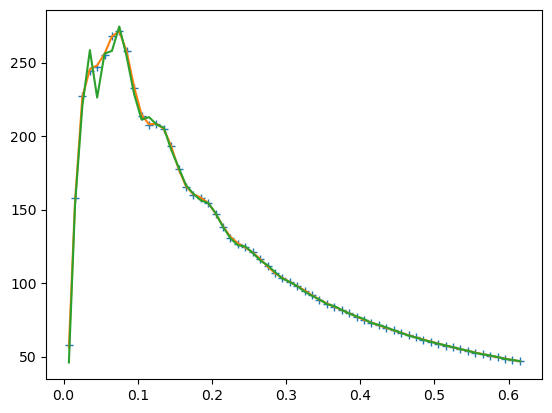

In [39]:
# plt.plot(klin, klin * pklin)
temp = np.array([init_poles.k, linear_pk_interp(fiduc_cosmo, a=1/(1+z))(init_poles.k)])
plt.plot(temp[0], temp[1] * temp[0], '+')
plt.plot(init_poles.k, init_poles.k * init_poles.power[0])
plt.plot(init_poles2.k, init_poles2.k * init_poles2.power[0])

In [86]:
# pk_bsmooth = np.copy(pk_biases)
# pk_bsmooth[:,1] = pk_biases[:,1] * (jnp.exp(-.5 * (pk_biases[:,0] / k_nyquist)**2))**2

# pklin = DESI().get_fourier().pk_interpolator().to_1d(z=z)
# klin, pklin = pklin.k, pklin.pk

# positions = mesh_init_r.pm.generate_uniform_particle_grid(shift=0.).copy()
# shifts = get_shifts(mesh_init_k, positions=positions)
# shifted_positions = positions + shifts

positions = mesh_init_r2.pm.generate_uniform_particle_grid(shift=0.).copy()
shifts = get_shifts(mesh_init_r2.r2c(), positions=positions)
shifted_positions = positions + shifts

list_bias = [-3.,0, 3.]
ells = (0,)
list_poles = []
for b2 in list_bias:
    bias = {'b1': 0.5, 'b2': b2, 'bs': 0., 'bk2': 0.}
    # weights = get_lagrangian_field(mesh_init_r, bias=list(bias.values()), smoothing=0, positions=positions)
    weights = get_lagrangian_field(mesh_init_r2, bias=list(bias.values()), smoothing=0, positions=positions)

    lbe_poles = CatalogFFTPower(data_positions1=shifted_positions, data_weights1=weights, edges=kedges, ells=ells, 
                            boxsize=boxsize, nmesh=nmesh, resampler='cic', interlacing=False, shotnoise=0., position_type='pos', wrap=True).poles
    list_poles.append(lbe_poles)
kv = lbe_poles.k


list_analytic = []
for b2, poles in zip(list_bias, list_poles):
    bias = {'b1': 0.5, 'b2': b2, 'bs': 0., 'bk2': 0.}
    if smooth:
        cutoff = k_nyquist
    else:
        cutoff = k_nyquist
    pktable = get_pt(kv, klin, pklin, cutoff=cutoff, f=None)
    # pktable = get_pt(kv, klin, pklin, cutoff=cutoff, f=f)
    analytic = get_pk(pktable, **bias)
    list_analytic.append(analytic)


pk_biases_pos = []
for b2, bias_pos, bias_weight in zip(list_bias, bias_poses, bias_weights):
    bias = {'b1': 0.5, 'b2': b2, 'bs': 0., 'bk2': 0.}
    # weights = get_lagrangian_field(mesh_init_r2, bias=list(bias.values()), smoothing=0, positions=positions)
    weights = bias_weight
    bias_pos_phy = bias_pos * (boxsize / nmesh)
    bias_poles = CatalogFFTPower(data_positions1=bias_pos_phy, data_weights1=weights, edges=kedges, ells=ells, 
                            boxsize=boxsize, nmesh=nmesh, resampler='cic', interlacing=False, shotnoise=0., position_type='pos', wrap=True).poles
    pk_biases_pos.append(bias_poles)

/local/home/hs276503/miniforge3/envs/obseletenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


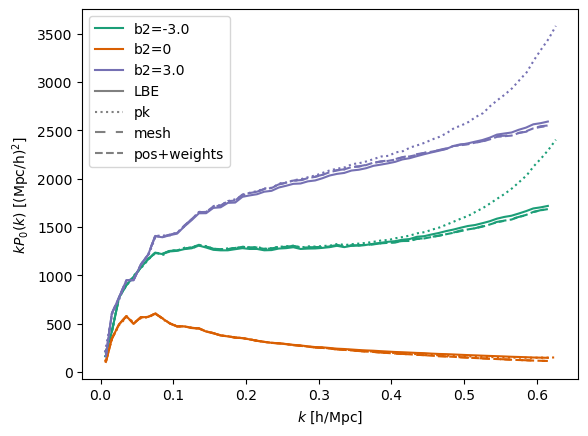

In [87]:
ax = plt.gca()
cmap = plt.get_cmap('Dark2')
iell = 0
# import matplotlib.patches as mpatches
for ibias, (poles, analytic, pkb, pkb_mesh, pkb_pos) in enumerate(zip(list_poles, list_analytic, pk_biases, pk_biases_mesh, pk_biases_pos)):
    # color = 'C{:d}'.format(ibias)
    color = cmap(ibias / 7)
    ax.plot(kv, kv * poles.power[iell], color=color, linestyle='-', label=f"b2={list_bias[ibias]}")
    # ax.plot(kv, kv * analytic[iell], color=color, linestyle='--')

    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)
    plot_fn(pkb, color=color, linestyle=':')
    ax.plot(kv, kv * pkb_mesh.power[iell], color=color, linestyle=(0, (5,5)))
    ax.plot(kv, kv * pkb_pos.power[iell], color=color, linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
from matplotlib.lines import Line2D
handles.append(Line2D([], [], color='grey', linestyle='-', label='LBE'))
# handles.append(Line2D([], [], color='grey', linestyle='--', label='ZeNBu'))
handles.append(Line2D([], [], color='grey', linestyle=':', label='pk'))
handles.append(Line2D([], [], color='grey', linestyle=(0, (5,5)), label='mesh'))
handles.append(Line2D([], [], color='grey', linestyle='--', label='pos+weights'))
plt.legend(handles=handles)
# plt.xlim(0, k_nyquist/2)
# max_y = (pk_biases[:3,0]*pk_biases[:3,1])[:,pk_biases.shape[2]//2].max()
# plt.ylim(0, max_y)
plt.ylabel(f"$k P_{0}(k)$ [(Mpc/h)$^2$]")
plt.xlabel("$k$ [h/Mpc]")
plt.savefig("pk_biases_256_1280_rsd0_smooth0.svg")
plt.show()